# Loading the Libraries

In [148]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import matplotlib.colorbar
import matplotlib.colors
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [149]:
from cvxopt import matrix,solvers

# Loading Railway Dataset

In [150]:
railway_data = pd.read_csv("data/railwayBookingList.csv")
railway_data = railway_data.dropna()

railway_data.loc[railway_data["sex"] == "male", "sex"] = 1
railway_data.loc[railway_data["sex"] == "female", "sex"] = 0

railway_data.loc[railway_data["preferredClass"] == "FIRST_AC", "preferredClass"] = 0
railway_data.loc[railway_data["preferredClass"] == "SECOND_AC", "preferredClass"] = 1
railway_data.loc[railway_data["preferredClass"] == "THIRD_AC", "preferredClass"] = 2

x = railway_data.drop(["caseID", "boarded"], axis = 1).values
y = railway_data["boarded"].values

#x = (x - x.mean(axis = 0)) / np.sqrt(x.var(axis = 0))


# Converting y to +1/-1 labels, for our SVM formulation

In [151]:
for i in range(y.shape[0]):
    if(y[i] == 0):
        y[i] = -1

In [152]:
print(y)

[-1 -1  1 ...  1  1  1]


In [153]:
def kernel(xi,xj):
    return np.dot(xi,xj)

# Some Implementational Notes
- CVXOPT requires double format
- CVXOPT requires matrix in it's own CVXOPT matrix format
- G to be given as list of it's columns
- For more information - https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
- Using the formulation with class label = +1/-1. 

# Preparing Objective Function

In [154]:
m = 1309
P = np.outer(y,y)

ker = np.empty([m,m])
for i in range(m):
    for j in range(m):
        ker[i,j] = kernel(x[i],x[j])
        
        
P = np.multiply(P,ker)
q = -1 * np.ones(m)

# Preparing "subject to" Constraint

In [155]:
# G has to be given in terms of it's columns. tolist() converts matrix to list of it's rows, so we take a transpose, since we 
# need the list of columns
G = -1 * np.identity(m)
G = G.astype('d')
G = (np.transpose(G)).tolist()
h = np.zeros(m)

# Preparing Ax = b

In [156]:
A = y.reshape((1,m))
b = np.array([0.0]).reshape((1,1))

# Converting into the CVXOPT matrix format

In [157]:
P = matrix(P.astype('d'))
q = matrix(q.astype('d'))
G = matrix(G)
h = matrix(h.astype('d'))
A = matrix(A.astype('d'))
b = matrix(b)

In [158]:
solution = solvers.qp(P,q,G,h,A,b)

     pcost       dcost       gap    pres   dres
 0: -8.0141e+02 -2.3718e+03  5e+03  4e+01  3e+00
 1: -3.9450e+03 -5.7007e+03  2e+03  2e+01  1e+00
 2: -1.1881e+04 -1.4046e+04  2e+03  2e+01  1e+00
 3: -7.1270e+04 -7.4410e+04  3e+03  2e+01  1e+00
 4: -6.5295e+05 -6.7184e+05  2e+04  1e+01  1e+00
 5: -7.5314e+06 -7.6846e+06  2e+05  1e+01  1e+00
 6: -7.5419e+06 -7.6953e+06  2e+05  1e+01  1e+00
 7: -8.0638e+06 -8.2276e+06  2e+05  1e+01  1e+00
 8: -9.0703e+06 -9.2541e+06  2e+05  1e+01  1e+00
 9: -1.9895e+07 -2.0288e+07  4e+05  1e+01  1e+00
10: -2.7041e+07 -2.7570e+07  5e+05  1e+01  1e+00
11: -2.7149e+07 -2.7680e+07  5e+05  1e+01  1e+00
12: -2.7668e+07 -2.8209e+07  5e+05  1e+01  1e+00
13: -3.2314e+07 -3.2941e+07  6e+05  1e+01  1e+00
14: -3.5277e+07 -3.5950e+07  7e+05  1e+01  1e+00
Terminated (singular KKT matrix).


In [159]:
u = solution['x']
u = np.array(u)
print(u)

[[  4858.09222883]
 [ 26890.05260987]
 [192303.86034358]
 ...
 [  7582.68507048]
 [  7582.52900735]
 [ 10779.81445845]]


In [168]:
S = u > 0
y_dash = y.reshape(y.shape[0],1)
print(y_dash)
w = np.multiply(u,y_dash)
print(w)
w = np.multiply(w,S)
print(w.shape)
w = np.multiply(x,w)
print(w)
w = w.sum(axis = 0)
print(w)

b = (y - np.dot(x,w))
b = b[1]
print(w)
print(b)

[[-1]
 [-1]
 [ 1]
 ...
 [ 1]
 [ 1]
 [ 1]]
[[ -4858.09222883]
 [-26890.05260987]
 [192303.86034358]
 ...
 [  7582.68507048]
 [  7582.52900735]
 [ 10779.81445845]]
(1309, 1)
[[-1.06926610e+07 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -9.71618446e+03]
 [-4.77298434e+07 -8.06701578e+04 -0.00000000e+00 -2.68900526e+04
  -0.00000000e+00]
 [ 3.41339352e+08  5.76911581e+05  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 ...
 [ 5.38370640e+06  0.00000000e+00  1.51653701e+04  7.58268507e+03
   1.51653701e+04]
 [ 5.38359560e+06  0.00000000e+00  1.51650580e+04  7.58252901e+03
   1.51650580e+04]
 [ 7.65366827e+06  0.00000000e+00  2.15596289e+04  1.07798145e+04
   2.15596289e+04]]
[-1.07288361e-06  4.94159758e-05 -4.88939520e-03 -2.20152745e-02
  4.83686803e-04]
[-1.07288361e-06  4.94159758e-05 -4.88939520e-03 -2.20152745e-02
  4.83686803e-04]
-0.9762286050245166


In [161]:
def predict_SVM(x,w,b):
    return np.dot(x,w)+b

In [162]:
y_pred = predict_SVM(x,w,b)

In [163]:
print(y_pred)

[-0.97762265 -1.         -0.97798473 ... -1.00781704 -1.00781704
 -1.00781704]


<IPython.core.display.Javascript object>


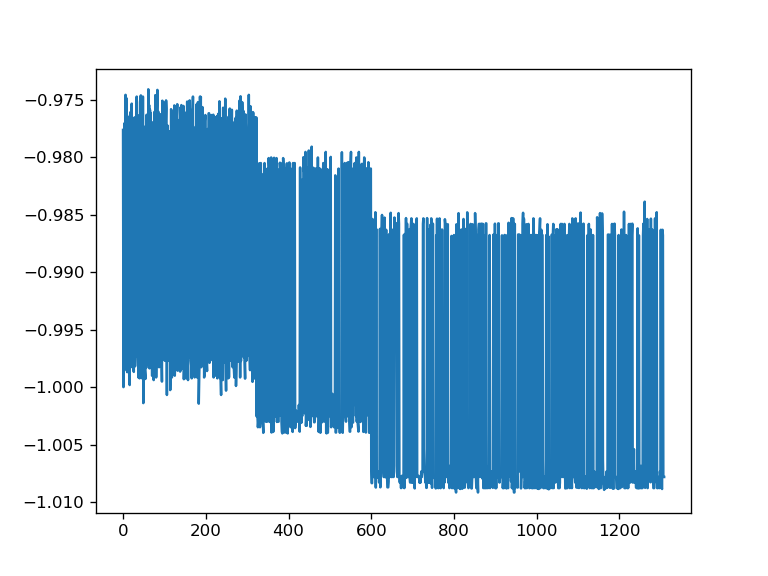

In [164]:
plt.plot(y_pred)